In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

In [28]:
def generate_circle_points_3d(center, normal, radius, n_points=100, noise_std=0.0, random_state=None):
    """
    Generate points on a 3D circle (optionally with Gaussian noise).

    Parameters
    ----------
    center : array-like, shape (3,)
        3D coordinates of the circle center.
    normal : array-like, shape (3,)
        Normal vector of the circle's plane (doesn't need to be unit).
    radius : float
        Circle radius.
    n_points : int
        Number of points on the circle.
    noise_std : float
        Standard deviation of Gaussian noise added to each coordinate.
    random_state : int or None
        Seed for reproducibility.

    Returns
    -------
    points : ndarray, shape (n_points, 3)
        Generated 3D points.
    """
    rng = np.random.default_rng(random_state)

    center = np.asarray(center, dtype=float)
    n = np.asarray(normal, dtype=float)
    n /= np.linalg.norm(n)

    # Build an orthonormal basis (u, v) in the plane
    # pick a vector not parallel to n
    if abs(n[0]) < abs(n[1]):
        if abs(n[0]) < abs(n[2]):
            ref = np.array([1.0, 0.0, 0.0])
        else:
            ref = np.array([0.0, 0.0, 1.0])
    else:
        if abs(n[1]) < abs(n[2]):
            ref = np.array([0.0, 1.0, 0.0])
        else:
            ref = np.array([0.0, 0.0, 1.0])

    u = ref - np.dot(ref, n) * n
    u /= np.linalg.norm(u)
    v = np.cross(n, u)

    # Sample angles
    t = rng.uniform(0, 2*np.pi, n_points)

    # Ideal circle points (no noise)
    circle_points = (center
                     + radius * np.cos(t)[:, None] * u
                     + radius * np.sin(t)[:, None] * v)

    # Add noise in 3D if requested
    if noise_std > 0:
        circle_points += rng.normal(scale=noise_std, size=circle_points.shape)

    return circle_points

def plot_ground_truth(center, radius, normal, ax):
    """
    Plots the ground-truth circle (center, radius, normal) as a red circle
    in the three subplot axes: ax[0] (x-y), ax[1] (x-z), ax[2] (y-z)
    """

    # Compute ideal circle points for plotting (no noise)
    n_plot = 200
    # Build orthonormal basis (u, v) in the plane
    n_vec = np.asarray(normal, dtype=float)
    n_vec /= np.linalg.norm(n_vec)
    # Pick reference vector not parallel to n
    if abs(n_vec[0]) < abs(n_vec[1]):
        if abs(n_vec[0]) < abs(n_vec[2]):
            ref = np.array([1.0, 0.0, 0.0])
        else:
            ref = np.array([0.0, 0.0, 1.0])
    else:
        if abs(n_vec[1]) < abs(n_vec[2]):
            ref = np.array([0.0, 1.0, 0.0])
        else:
            ref = np.array([0.0, 0.0, 1.0])
    u = ref - np.dot(ref, n_vec) * n_vec
    u /= np.linalg.norm(u)
    v = np.cross(n_vec, u)
    # Angles for the circle
    theta = np.linspace(0, 2*np.pi, n_plot)
    circle = (center
              + radius * np.cos(theta)[:, None] * u
              + radius * np.sin(theta)[:, None] * v)
    # Plot projections
    ax[0].plot(circle[:, 0], circle[:, 1], 'r-', label='Ground truth')
    ax[1].plot(circle[:, 0], circle[:, 2], 'r-', label='Ground truth')
    ax[2].plot(circle[:, 1], circle[:, 2], 'r-', label='Ground truth')
    
    # plot center as a point
    ax[0].scatter(center[0], center[1], s= 50, label='Center')
    ax[1].scatter(center[0], center[2], s= 50, label='Center')
    ax[2].scatter(center[1], center[2], s= 50, label='Center')


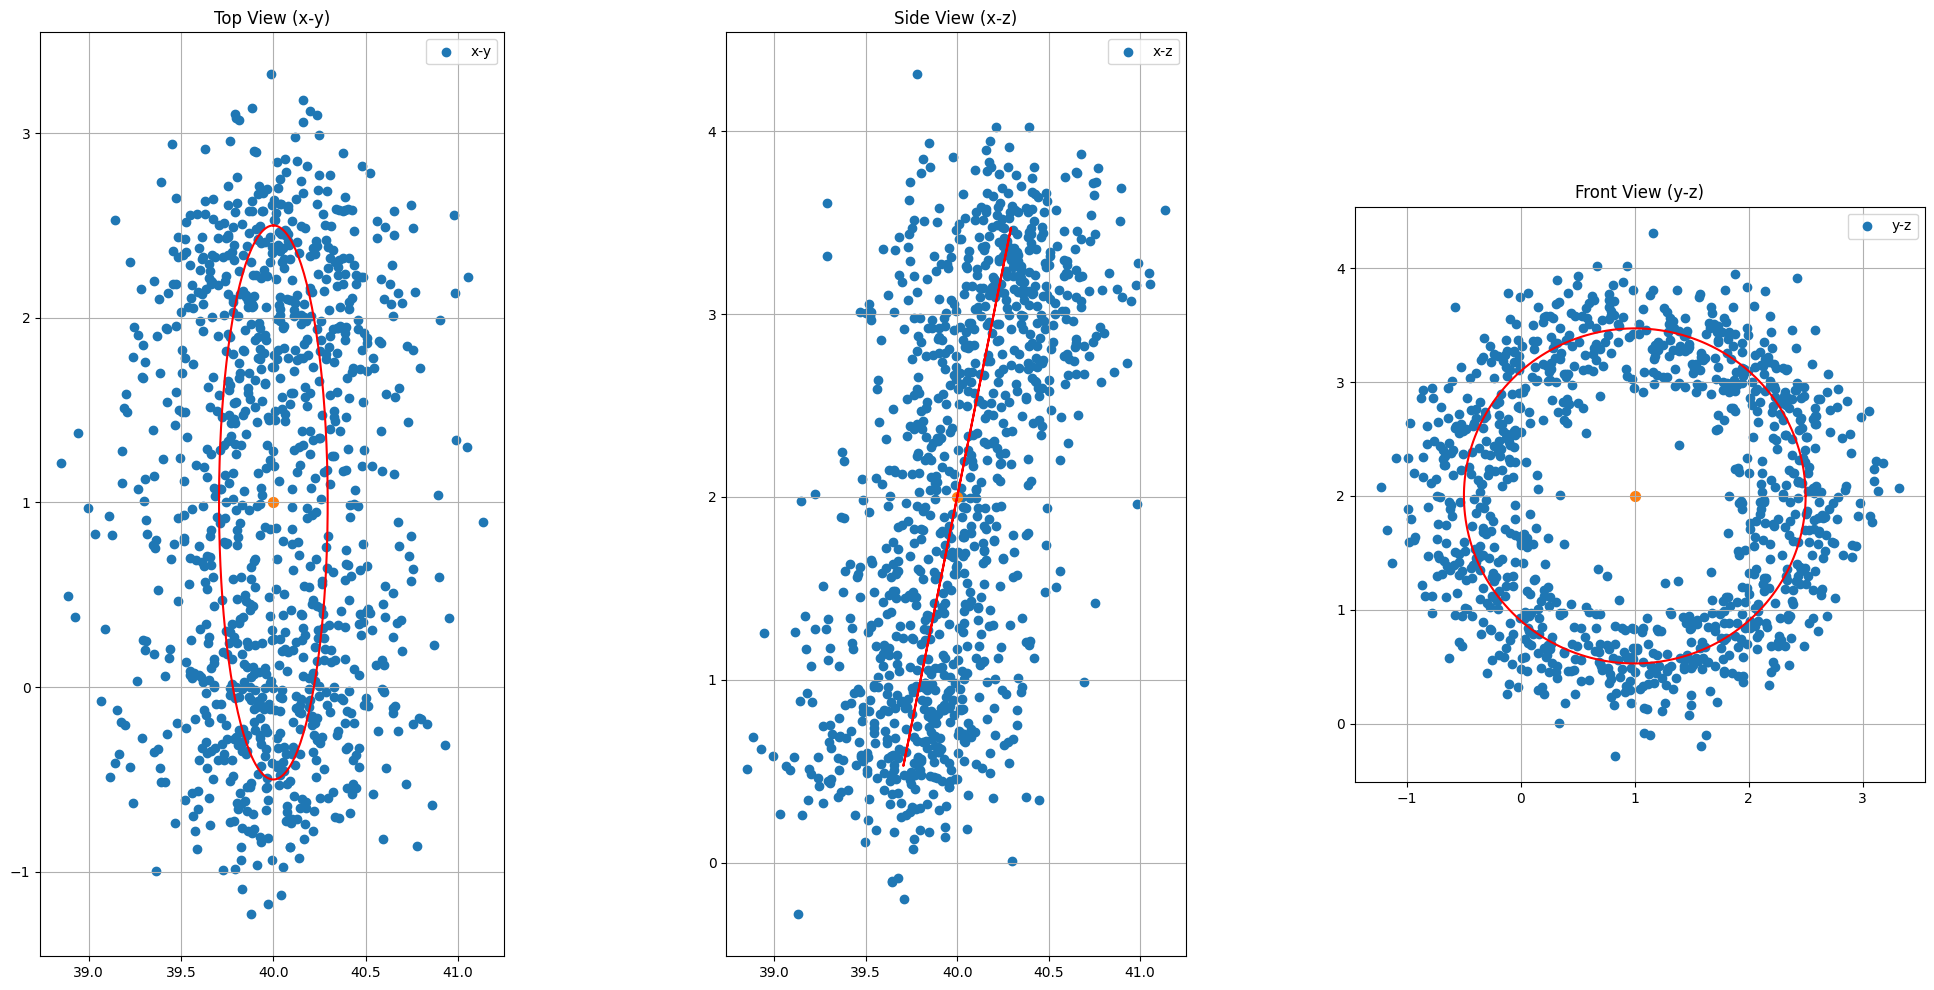

In [53]:
center = np.array([40, 1, 2])
normal = np.array([1, 0, -0.2])
radius = 1.5
n_points = 1000
noise_std = 0.3
random_state = 42
points = generate_circle_points_3d(center, normal, radius, n_points, noise_std, random_state)

# # filter out points that are top 90% in z 
# points = points[points[:, 2] < np.percentile(points[:, 2], 90)]

# Create subplots in 1 row and 3 columns
fig, ax = plt.subplots(1, 3, figsize=(25, 12))  # wider for horizontal layout

# Scatter plots for each projection
ax[0].scatter(points[:, 0], points[:, 1], label='x-y')
ax[1].scatter(points[:, 0], points[:, 2], label='x-z')
ax[2].scatter(points[:, 1], points[:, 2], label='y-z')

# Add legend and grid to each axis
for axis in ax:
    axis.legend()
    axis.set_aspect('equal')
    axis.grid(True)

# Set titles for each subplot
ax[0].set_title('Top View (x-y)')
ax[1].set_title('Side View (x-z)')
ax[2].set_title('Front View (y-z)')

plot_ground_truth(center, radius, normal, ax)
plt.show()



In [54]:
np.mean(points, axis=0)

array([39.99700047,  1.01917845,  1.99947207])

In [ ]:
## Fit best fit plane to points 
# get centroid 
centroid = np.mean(points, axis=0)
# offset by centroid
points_centered = points - centroid
# get covariance matrix 
cov_matrix = np.cov(points_centered, rowvar=False)

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)


array([[0.14205642, 0.0115869 , 0.23136224],
       [0.0115869 , 1.22088235, 0.01900455],
       [0.23136224, 0.01900455, 1.16623903]])

In [49]:
np.linalg.svd(cov_matrix)

SVDResult(U=array([[-0.02033381,  0.22410578, -0.97435268],
       [-0.99820366, -0.05948389,  0.00714998],
       [-0.05635593,  0.97274779,  0.22491274]]), S=array([1.30782739, 1.01510579, 0.09100388]), Vh=array([[-0.02033381, -0.99820366, -0.05635593],
       [ 0.22410578, -0.05948389,  0.97274779],
       [-0.97435268,  0.00714998,  0.22491274]]))